# K리그 관중 예측 - 피처 엔지니어링

분석 인사이트를 바탕으로 예측 모델에 사용할 피처를 생성합니다.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

DB_PATH = "..\\data\\match.db"

In [2]:
# 원본 데이터 로드
with sqlite3.connect(DB_PATH) as conn:
    query = """
            SELECT *
            FROM kleague
            WHERE Audience_Qty > 0
            """
    df = pd.read_sql(query, conn)

print(f"데이터 크기: {df.shape}")
df.head()

데이터 크기: (4413, 49)


,Meet_Year,LEAGUE_NAME,Round,Game_id,Game_Datetime,Day,HomeTeam,AwayTeam,HomeRank,AwayRank,...,home_first_45_possession,home_second_15_possession,home_second_30_possession,home_second_45_possession,away_first_15_possession,away_first_30_possession,away_first_45_possession,away_second_15_possession,away_second_30_possession,away_second_45_possession
0,2015,K리그1,1,1,2015-03-07 15:00:00,토,전북,성남,0,0,...,61.73,56.51,56.21,52.75,40.48,39.72,38.27,43.49,43.79,47.25
1,2015,K리그1,1,2,2015-03-07 14:00:00,토,인천,광주,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2015,K리그1,1,3,2015-03-07 16:00:00,토,부산,대전,0,0,...,52.49,48.95,54.37,49.60,49.04,48.87,47.51,51.05,45.63,50.40
3,2015,K리그1,1,4,2015-03-08 14:00:00,일,전남,제주,0,0,...,49.65,53.19,56.48,58.66,43.48,53.06,50.35,46.81,43.52,41.34
4,2015,K리그1,1,5,2015-03-08 14:00:00,일,수원,포항,0,0,...,54.50,54.36,47.23,48.95,34.87,39.31,45.50,45.64,52.77,51.05


---
## 1. 시간 관련 피처

In [3]:
# 1-1. 시간 관련 피처 생성
df['Game_Datetime'] = pd.to_datetime(df['Game_Datetime'])

# 월
df['month'] = df['Game_Datetime'].dt.month

# 시간대
df['hour'] = df['Game_Datetime'].dt.hour

# 주말 여부 (토=5, 일=6)
df['is_weekend'] = df['Day'].isin(['토', '일']).astype(int)

# 시즌 단계 (1: 초반, 2: 중반, 3: 후반, 4: 막판)
df['season_phase'] = pd.cut(df['Round'], 
                            bins=[0, 10, 20, 30, 50], 
                            labels=[1, 2, 3, 4]).astype(int)

print("시간 관련 피처 생성 완료")
df[['Game_Datetime', 'month', 'hour', 'Day', 'is_weekend', 'Round', 'season_phase']].head(10)

시간 관련 피처 생성 완료


,Game_Datetime,month,hour,Day,is_weekend,Round,season_phase
0,2015-03-07 15:00:00,3,15,토,1,1,1
1,2015-03-07 14:00:00,3,14,토,1,1,1
2,2015-03-07 16:00:00,3,16,토,1,1,1
3,2015-03-08 14:00:00,3,14,일,1,1,1
4,2015-03-08 14:00:00,3,14,일,1,1,1
5,2015-03-08 16:00:00,3,16,일,1,1,1
6,2015-03-14 14:00:00,3,14,토,1,2,1
7,2015-03-14 14:00:00,3,14,토,1,2,1
8,2015-03-14 16:00:00,3,16,토,1,2,1
9,2015-03-15 14:00:00,3,14,일,1,2,1


---
## 2. 팀 관련 피처

In [4]:
# 2-1. 팀별 평균 홈 관중수 계산 (팀 인기도 지표)
team_popularity = df.groupby('HomeTeam')['Audience_Qty'].mean().to_dict()

# 홈팀 인기도
df['home_team_popularity'] = df['HomeTeam'].map(team_popularity)

# 원정팀 인기도 (원정팬 유입 효과)
df['away_team_popularity'] = df['AwayTeam'].map(team_popularity)

print("팀 인기도 (평균 홈 관중수 기준):")
popularity_df = pd.DataFrame.from_dict(team_popularity, orient='index', columns=['avg_audience'])
display(popularity_df.sort_values('avg_audience', ascending=False).head(10))

팀 인기도 (평균 홈 관중수 기준):


,avg_audience
서울,16982.928962
전북,12916.222798
울산,10292.927835
수원,9274.446237
포항,7562.417526
인천,6806.835106
대구,6396.743590
대전,4783.494792
제주,4710.260638
성남,3468.670270


In [5]:
# 2-2. 더비 매치 피처
# 같은 지역/라이벌 팀 매치
derby_pairs = [
    # 수도권 더비
    ('서울', '서울E'), ('서울', '수원'), ('서울', '수원FC'), ('서울', '인천'),
    ('수원', '수원FC'), ('수원', '인천'), ('수원', '서울E'),
    ('인천', '서울E'), ('인천', '수원FC'),
    # 영남 더비
    ('울산', '포항'), ('울산', '대구'), ('울산', '경남'), ('울산', '부산'),
    ('포항', '대구'), ('포항', '경남'), ('포항', '부산'),
    ('대구', '경남'), ('대구', '부산'),
    ('경남', '부산'),
    # 호남 더비
    ('전북', '전남'), ('전북', '광주'),
    ('전남', '광주'),
    # K리그 클래식 라이벌
    ('전북', '울산'), ('전북', '서울'), ('울산', '서울'),
]

def is_derby(home, away):
    return int((home, away) in derby_pairs or (away, home) in derby_pairs)

df['is_derby'] = df.apply(lambda x: is_derby(x['HomeTeam'], x['AwayTeam']), axis=1)

print(f"더비 매치 수: {df['is_derby'].sum()} / {len(df)} ({df['is_derby'].mean()*100:.1f}%)")
print(f"\n더비 매치 평균 관중: {df[df['is_derby']==1]['Audience_Qty'].mean():,.0f}")
print(f"일반 매치 평균 관중: {df[df['is_derby']==0]['Audience_Qty'].mean():,.0f}")

더비 매치 수: 457 / 4413 (10.4%)

더비 매치 평균 관중: 11,150
일반 매치 평균 관중: 4,286


---
## 3. 순위/성적 관련 피처

In [6]:
# 3-1. 순위 관련 피처
# 순위 합계 (빅매치 지표 - 낮을수록 빅매치)
df['rank_sum'] = df['HomeRank'] + df['AwayRank']

# 순위 차이 (절대값)
df['rank_diff'] = abs(df['HomeRank'] - df['AwayRank'])

# 빅매치 여부 (상위 6위 이내 팀 간 대결)
df['is_big_match'] = ((df['HomeRank'] <= 6) & (df['AwayRank'] <= 6) & 
                       (df['HomeRank'] > 0) & (df['AwayRank'] > 0)).astype(int)

# 승점 합계
df['points_sum'] = df['HomePoints'] + df['AwayPoints']

# 승점 차이
df['points_diff'] = abs(df['HomePoints'] - df['AwayPoints'])

print(f"빅매치 수: {df['is_big_match'].sum()} / {len(df)} ({df['is_big_match'].mean()*100:.1f}%)")
print(f"\n빅매치 평균 관중: {df[df['is_big_match']==1]['Audience_Qty'].mean():,.0f}")
print(f"일반 매치 평균 관중: {df[df['is_big_match']==0]['Audience_Qty'].mean():,.0f}")

빅매치 수: 1081 / 4413 (24.5%)

빅매치 평균 관중: 6,087
일반 매치 평균 관중: 4,643


---
## 4. 날씨/환경 관련 피처

In [7]:
# 4-1. 날씨 관련 피처
# 적정 기온 여부 (15-25도)
df['is_good_temp'] = ((df['Temperature'] >= 15) & (df['Temperature'] <= 25)).astype(int)

# 날씨 카테고리 (맑음 계열 vs 비/흐림 계열)
good_weather = ['맑음', '구름조금', '구름많음']
df['is_good_weather'] = df['Weather'].isin(good_weather).astype(int)

# 기온 구간
df['temp_range'] = pd.cut(df['Temperature'], 
                          bins=[-np.inf, 10, 15, 20, 25, 30, np.inf],
                          labels=[0, 1, 2, 3, 4, 5]).astype(float)

print("날씨 피처 생성 완료")
print(f"\n적정 기온(15-25도) 경기: {df['is_good_temp'].sum()} ({df['is_good_temp'].mean()*100:.1f}%)")
print(f"좋은 날씨 경기: {df['is_good_weather'].sum()} ({df['is_good_weather'].mean()*100:.1f}%)")

날씨 피처 생성 완료

적정 기온(15-25도) 경기: 1628 (36.9%)
좋은 날씨 경기: 2845 (64.5%)


---
## 5. 리그/시즌 관련 피처

In [8]:
# 5-1. 리그 관련 피처
# K리그1 여부
df['is_k1'] = (df['LEAGUE_NAME'] == 'K리그1').astype(int)

# 코로나 시기 여부 (2020-2021)
df['is_covid'] = df['Meet_Year'].isin([2020, 2021]).astype(int)

print(f"K리그1 경기: {df['is_k1'].sum()} ({df['is_k1'].mean()*100:.1f}%)")
print(f"코로나 시기 경기: {df['is_covid'].sum()} ({df['is_covid'].mean()*100:.1f}%)")

K리그1 경기: 2276 (51.6%)
코로나 시기 경기: 402 (9.1%)


---
## 6. 타겟 변환

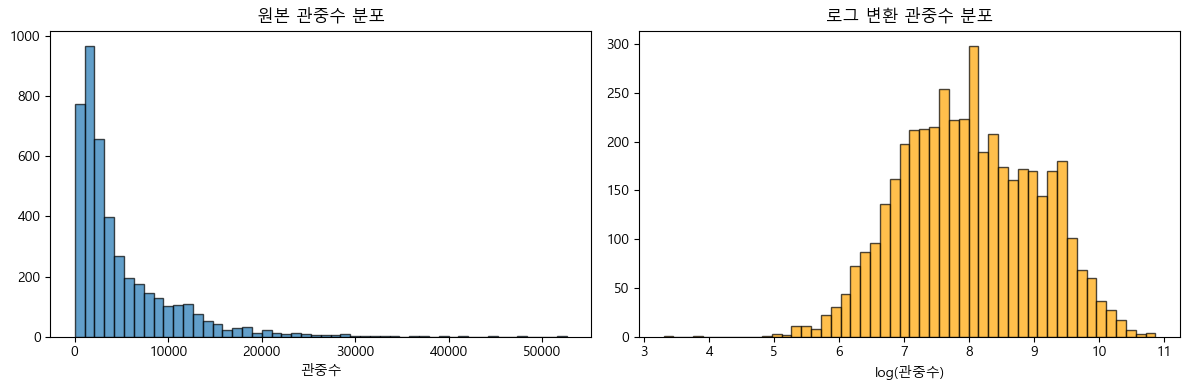

원본 왜도(Skewness): 2.516
로그 변환 왜도(Skewness): -0.005


In [9]:
# 6-1. 로그 변환 타겟
df['log_audience'] = np.log1p(df['Audience_Qty'])

# 변환 전후 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['Audience_Qty'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('원본 관중수 분포')
axes[0].set_xlabel('관중수')

axes[1].hist(df['log_audience'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('로그 변환 관중수 분포')
axes[1].set_xlabel('log(관중수)')

plt.tight_layout()
plt.show()

print(f"원본 왜도(Skewness): {df['Audience_Qty'].skew():.3f}")
print(f"로그 변환 왜도(Skewness): {df['log_audience'].skew():.3f}")

---
## 7. 범주형 변수 인코딩

In [10]:
# 7-1. 요일 인코딩 (Label Encoding)
day_map = {'월': 0, '화': 1, '수': 2, '목': 3, '금': 4, '토': 5, '일': 6}
df['day_encoded'] = df['Day'].map(day_map)

# 7-2. 날씨 인코딩
weather_map = {
    '맑음': 0, '구름조금': 1, '구름많음': 2, '흐림': 3, 
    '안개': 4, '비': 5, '소나기': 6, '눈': 7
}
df['weather_encoded'] = df['Weather'].map(weather_map).fillna(3)  # 없는 값은 흐림으로

print("범주형 변수 인코딩 완료")
df[['Day', 'day_encoded', 'Weather', 'weather_encoded']].drop_duplicates().head(10)

범주형 변수 인코딩 완료


,Day,day_encoded,Weather,weather_encoded
0,토,5,맑음,0.0
3,일,6,맑음,0.0
19,토,5,흐림,3.0
20,토,5,흐리고 비,3.0
22,일,6,흐림,3.0
23,일,6,흐리고 비,3.0
30,수,2,맑음,0.0
34,수,2,흐림,3.0
38,토,5,비,5.0
39,일,6,비,5.0


---
## 8. 최종 피처 정리

In [11]:
# 8-1. 최종 피처 목록
feature_cols = [
    # 원본 수치형
    'Round', 'HomeRank', 'AwayRank', 'HomePoints', 'AwayPoints',
    'Temperature', 'Humidity',
    
    # 시간 관련
    'month', 'hour', 'is_weekend', 'season_phase', 'day_encoded',
    
    # 팀 관련
    'home_team_popularity', 'away_team_popularity', 'is_derby',
    
    # 순위/성적 관련
    'rank_sum', 'rank_diff', 'is_big_match', 'points_sum', 'points_diff',
    
    # 날씨/환경 관련
    'is_good_temp', 'is_good_weather', 'temp_range', 'weather_encoded',
    
    # 리그/시즌 관련
    'is_k1', 'is_covid'
]

# 타겟
target_col = 'Audience_Qty'
log_target_col = 'log_audience'

# 식별 컬럼 (Round는 feature_cols에 있으므로 제외)
id_cols = ['Meet_Year', 'LEAGUE_NAME', 'Game_id', 'Game_Datetime',
           'HomeTeam', 'AwayTeam', 'Field_Name']

print(f"총 피처 수: {len(feature_cols)}")
print(f"\n피처 목록:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

총 피처 수: 26

피처 목록:
  1. Round
  2. HomeRank
  3. AwayRank
  4. HomePoints
  5. AwayPoints
  6. Temperature
  7. Humidity
  8. month
  9. hour
  10. is_weekend
  11. season_phase
  12. day_encoded
  13. home_team_popularity
  14. away_team_popularity
  15. is_derby
  16. rank_sum
  17. rank_diff
  18. is_big_match
  19. points_sum
  20. points_diff
  21. is_good_temp
  22. is_good_weather
  23. temp_range
  24. weather_encoded
  25. is_k1
  26. is_covid


In [12]:
# 8-2. 결측치 확인
missing = df[feature_cols].isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_count', ascending=False)

if len(missing_df) > 0:
    print("결측치가 있는 피처:")
    display(missing_df)
else:
    print("결측치 없음!")

결측치 없음!


In [13]:
# 8-3. 결측치 처리
# 수치형 피처는 중앙값으로 대체
numeric_features = ['Temperature', 'Humidity', 'temp_range', 
                    'home_team_popularity', 'away_team_popularity']

for col in numeric_features:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"{col}: 결측치를 중앙값({median_val:.2f})으로 대체")

# 순위 0인 경우 처리 (시즌 초반 순위 미정)
df.loc[df['HomeRank'] == 0, 'HomeRank'] = 6  # 중간 순위로 대체
df.loc[df['AwayRank'] == 0, 'AwayRank'] = 6

# rank_sum, rank_diff 재계산
df['rank_sum'] = df['HomeRank'] + df['AwayRank']
df['rank_diff'] = abs(df['HomeRank'] - df['AwayRank'])

print("\n결측치 처리 완료!")


결측치 처리 완료!


In [14]:
# 8-4. 최종 데이터셋 생성
# 중복 컬럼 방지를 위해 순서대로 선택
all_cols = id_cols + feature_cols + [target_col, log_target_col]
# 중복 제거 (순서 유지)
unique_cols = list(dict.fromkeys(all_cols))
df_final = df[unique_cols].copy()

print(f"최종 데이터셋 크기: {df_final.shape}")
print(f"\n컬럼 구성:")
print(f"  - 식별 컬럼: {len(id_cols)}개")
print(f"  - 피처 컬럼: {len(feature_cols)}개")
print(f"  - 타겟 컬럼: 2개 (원본, 로그변환)")

df_final.head()

최종 데이터셋 크기: (4413, 35)

컬럼 구성:
  - 식별 컬럼: 7개
  - 피처 컬럼: 26개
  - 타겟 컬럼: 2개 (원본, 로그변환)


,Meet_Year,LEAGUE_NAME,Game_id,Game_Datetime,HomeTeam,AwayTeam,Field_Name,Round,HomeRank,AwayRank,...,points_sum,points_diff,is_good_temp,is_good_weather,temp_range,weather_encoded,is_k1,is_covid,Audience_Qty,log_audience
0,2015,K리그1,1,2015-03-07 15:00:00,전북,성남,전주 월드컵 경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,23810,10.077903
1,2015,K리그1,2,2015-03-07 14:00:00,인천,광주,인천 축구 전용경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,8012,8.988821
2,2015,K리그1,3,2015-03-07 16:00:00,부산,대전,부산 아시아드 경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,9082,9.114160
3,2015,K리그1,4,2015-03-08 14:00:00,전남,제주,광양 전용 구장,1,6,6,...,0,0,0,1,1.0,0.0,1,0,12608,9.442166
4,2015,K리그1,5,2015-03-08 14:00:00,수원,포항,수원 월드컵 경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,17573,9.774176


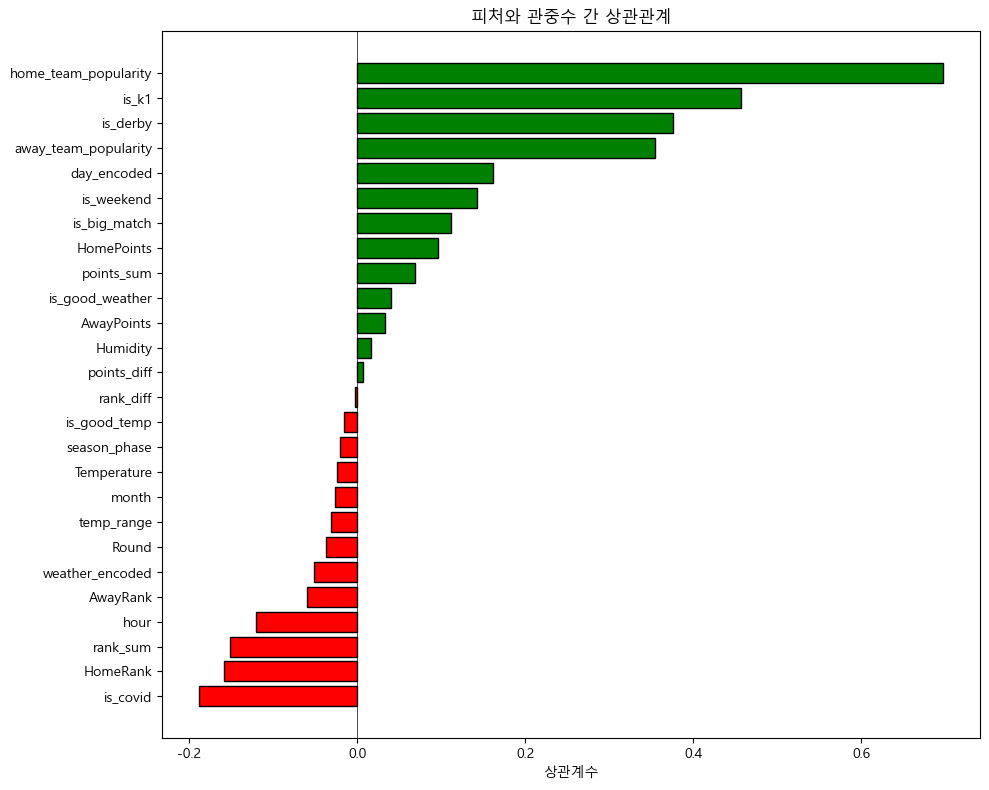


상관관계 Top 10:


,correlation
home_team_popularity,0.697067
is_k1,0.457043
is_derby,0.375294
away_team_popularity,0.354409
day_encoded,0.162136
is_weekend,0.142796
is_big_match,0.111421
HomePoints,0.095700
points_sum,0.068885
is_good_weather,0.039928


In [15]:
# 8-5. 피처와 타겟 간 상관관계 확인
correlations = df_final[feature_cols + [target_col]].corr()[target_col].drop(target_col)
correlations = correlations.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in correlations.values]
bars = ax.barh(correlations.index[::-1], correlations.values[::-1], color=colors[::-1], edgecolor='black')

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('상관계수')
ax.set_title('피처와 관중수 간 상관관계')
plt.tight_layout()
plt.show()

print("\n상관관계 Top 10:")
display(correlations.head(10).to_frame(name='correlation'))

---
## 9. 데이터 저장

In [16]:
# 9-1. CSV 파일로 저장
output_path = "..\\data\\kleague_features.csv"
df_final.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"데이터 저장 완료: {output_path}")

# 9-2. 피처 정보 저장
corr_dict = correlations.to_dict()
dtypes_dict = df_final.dtypes.to_dict()

feature_info = pd.DataFrame({
    'feature': feature_cols,
    'dtype': [str(dtypes_dict[col]) for col in feature_cols],
    'non_null': [df_final[col].notna().sum() for col in feature_cols],
    'unique': [df_final[col].nunique() for col in feature_cols],
    'correlation': [corr_dict.get(col, 0) for col in feature_cols]
})
feature_info.to_csv("..\\data\\feature_info.csv", index=False, encoding='utf-8-sig')
print(f"피처 정보 저장 완료: ..\\data\\feature_info.csv")

데이터 저장 완료: ..\data\kleague_features.csv
피처 정보 저장 완료: ..\data\feature_info.csv


In [17]:
# 9-3. 최종 요약
print("="*60)
print("피처 엔지니어링 완료!")
print("="*60)
print(f"\n총 샘플 수: {len(df_final):,}")
print(f"총 피처 수: {len(feature_cols)}")
print(f"\n생성된 파일:")
print(f"  1. kleague_features.csv - 모델 학습용 데이터셋")
print(f"  2. feature_info.csv - 피처 메타데이터")
print(f"\n다음 단계: 모델링 (train/test 분할 → 베이스라인 모델 → 튜닝)")

피처 엔지니어링 완료!

총 샘플 수: 4,413
총 피처 수: 26

생성된 파일:
  1. kleague_features.csv - 모델 학습용 데이터셋
  2. feature_info.csv - 피처 메타데이터

다음 단계: 모델링 (train/test 분할 → 베이스라인 모델 → 튜닝)
